So far in this module, we have discussed variable types and data cleaning with the goal of "understanding the data." By "understanding" the data, we mean uncovering insights, relationships, and patterns in it. These discoveries become assets for building our data science model, and then, ultimately, deriving business value. 

We set the stage for valid data analysis in the last checkpoints by handling missing values, outliers, and other data cleaning tasks. In this checkpoint, we make our 1st effort toward understanding the data by exploring it.

![data_exploration.png](data_exploration.png)

The data exploration step comes after the data cleaning step because problems in the data, such as outliers, have the potential to affect our exploration and lead to false conclusions. 

Only *after* we have attempted to eliminate those problems with data cleaning should we move to data exploration. However, this sequence *doesn't* mean the path from data cleaning to data exploration is a one-way street. Rather, as the figure above suggests, it's a two-way, iterative process that starts with cleaning, moves to exploration, and then cycles back and forth between these steps. 

Why the extra work? As we begin to further handle the data, we will discover previously unnoticed problems. Once a new problem is detected, we should eliminate it and return to the data exploration phase. We've said it before and we'll say it again: *EDA is an iterative process*. And data scientists regularly cycle between its steps several times before even beginning to model the data. 

Before going further, let's clarify some terminology. On the internet, you might come across articles that describe EDA as data exploration alone and treat data cleaning and feature engineering as discrete phases differing from our three step, cyclical conceptualization. Don't get too hung up on labelling. Regardless of how these processes are "bucketed," each process is essential for any data science project. 

In our conceptualization, **data exploration** is the process of applying statistics and visualization techniques to uncover the hidden information in data. In this process, not only do we begin to discover useful features, but we also learn to ask the right questions about the data. In this respect, we can think of data exploration as a dialogue between the data scientist and the data where the **data speaks for itself**. 

In the data exploration phase:

* Investigate the properties of variables in our dataset.
* Discover associations between the variables.
* Identify useful features that may help us to explain our target variables.
* Test for assumptions in the data.

As you will see in the next section, there is some overlap in the methods we use for data cleaning and data exploration.

As mentioned before, every successful data science project rests upon a thoroughly implemented EDA. This is why you will see large sections of successful Kaggle solutions dedicated to data exploration. The same is true for any successful real world project.

In this checkpoint, we will explore the data from several angles. Each perspective will show the data in a different light and build our understanding. At the most basic level, data exploration falls into 2 techniques:

* Univariate analysis and descriptive statistics.
* Multivariate analysis.

# Univariate analysis

A typical dataset consists of several variables. The first thing to do in data exploration is to investigate each variable at a time. That is called **univariate analysis**, and we aim to answer questions like:


* <font color=green>How many variables do we have</font>?
* <font color=green>How many datapoints are there in the dataset</font>?
* <font color=green>Which variables are continuous and which are categorical</font>?
* <font color=green>Are there any missing data? If so, how much</font>?
* Do any of the variables have a known probability distribution (normal, Poisson, Gamma, etc.)?
* What are the central tendencies of each of the variables?
* How much variance is there in each of the variables?

You might be wondering why are some of these bullet points green? It's because we covered them in the previous checkpoint! Since we already learned how to answer those, here we learn how to answer the next 3 questions.

Let's continue exploring the YouTube dataset example we've used. We'll set up our environment and then clean the data using the methods described in the previous checkpoint: 

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'youtube'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

youtube_df = pd.read_sql_query('select * from youtube',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

# we're dealing with the missing values

youtube_df["Video Uploads"] = youtube_df["Video Uploads"].apply(str.strip).replace("--", np.nan)
youtube_df["Video Uploads"] = pd.to_numeric(youtube_df["Video Uploads"], downcast="float")

youtube_df["Subscribers"] = youtube_df["Subscribers"].apply(str.strip).replace("--", np.nan)
youtube_df["Subscribers"] = pd.to_numeric(youtube_df["Subscribers"], downcast="float")

youtube_df.Grade = youtube_df.Grade.apply(str.strip).replace("", np.nan)


youtube_df["Video Uploads"].fillna(youtube_df["Video Uploads"].mean(), inplace=True)
youtube_df["Subscribers"].fillna(youtube_df["Subscribers"].mean(), inplace=True)


# We apply one-way winsorization to the highest end
# of the value distribution. As we have a lot of extreme
# values, we set the values of the outliers to the 
# value of the 90th percentile. 
youtube_df["winsorized_uploads"] = winsorize(youtube_df["Video Uploads"], (0, 0.10))
youtube_df["winsorized_subscribers"] = winsorize(youtube_df["Subscribers"], (0, 0.10))
youtube_df["winsorized_views"] = winsorize(youtube_df["Video views"], (0, 0.10))

for i in range(0, len(youtube_df.Grade)):
    if pd.isnull(youtube_df.Grade[i]):
        youtube_df.Grade[i] = youtube_df.Grade[i-1]

Now, let's begin our data exploration.

Pandas' `.describe()` function is a good starting point for univariate analysis:

In [2]:
# get univariate statistics
youtube_df.describe()

,Video Uploads,Subscribers,Video views,winsorized_uploads,winsorized_subscribers,winsorized_views
count,5000.000000,5000.0,5.000000e+03,5000.000000,5000.000,5.000000e+03
mean,3859.463623,2620004.0,1.071449e+09,1288.413818,2081596.625,7.828476e+08
std,17075.609375,3771402.5,2.003844e+09,1779.181152,1781477.500,7.754301e+08
min,1.000000,301.0,7.500000e+01,1.000000,301.000,7.500000e+01
25%,141.000000,666802.5,1.862329e+08,141.000000,666802.500,1.862329e+08
50%,445.000000,1544402.0,4.820548e+08,445.000000,1544402.000,4.820548e+08
75%,1511.500000,2723181.5,1.124368e+09,1511.500000,2723181.500,1.124368e+09
max,422326.000000,65995312.0,4.754884e+10,5653.000000,5895361.000,2.468241e+09


According to Pandas official documentation, the `.describe` function "generates descriptive statistics that summarize the central tendency, dispersion, and shape of a dataset’s distribution, excluding NaN values" ([read more here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.describe.html)). 

This method returns common statistics like means, counts, and quartiles for numeric variables. These are known as **descriptive statistics** and are foundational to data exploration.

The `.describe` function will also return relevant descriptive statistics for string based variables, such as counts and frequencies. However, these results are excluded by default. If we want to include descriptive statistics for string based variables, we can use `include=['O']` to see *just* the text variables, or  `include='all' to see *all* variables:

In [3]:
# descriptive statistics for just text-based variables
youtube_df.describe(include=['O'])

,Rank,Grade,Channel name
count,5000,5000,5000
unique,5000,5,4993
top,"3,854th",B+,Bollywood Classics
freq,1,2960,2


In [4]:
# descriptive statistics for all variables
youtube_df.describe(include= 'all')

,Rank,Grade,Channel name,Video Uploads,Subscribers,Video views,winsorized_uploads,winsorized_subscribers,winsorized_views
count,5000,5000,5000,5000.000000,5000.0,5.000000e+03,5000.000000,5000.000,5.000000e+03
unique,5000,5,4993,NaN,NaN,NaN,NaN,NaN,NaN
top,"3,854th",B+,Bollywood Classics,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,2960,2,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,3859.463623,2620004.0,1.071449e+09,1288.413818,2081596.625,7.828476e+08
std,NaN,NaN,NaN,17075.609375,3771402.5,2.003844e+09,1779.181152,1781477.500,7.754301e+08
min,NaN,NaN,NaN,1.000000,301.0,7.500000e+01,1.000000,301.000,7.500000e+01
25%,NaN,NaN,NaN,141.000000,666802.5,1.862329e+08,141.000000,666802.500,1.862329e+08
50%,NaN,NaN,NaN,445.000000,1544402.0,4.820548e+08,445.000000,1544402.000,4.820548e+08
75%,NaN,NaN,NaN,1511.500000,2723181.5,1.124368e+09,1511.500000,2723181.500,1.124368e+09


If we compare the means of the original and the winsorized variables above, we can notice the difference:

* The mean of the video uploads is 3,860, whereas it's 1,288 for the winsorized variant. A similar magnitude of difference is also observable for the other variables.

This is just a demonstration of how outliers affect the descriptive statistics. You should always be careful with extreme values as they tend to significantly affect the results of your analysis. Hence, if we want to summarize the central tendency in our data using the mean, we should always take into account the effects of outliers, and ideally, we should work on a cleaned variable (in this example, the winsorized versions).

## Univariate visualization

One of the most effective ways of exploring the data is to visualize it. Using graphics and illustrations, our brains grasp patterns and relationships quickly and effectively. Many of us prefer a straightforward graph to a sea of figures.

### Univariate visualization of continuous variables

One important aspect of any variable is its distribution. When exploring variables 1 by 1, we often try to understand the distributions of the variables by sketching their histograms. Recall from statistics data scientists admire the normal distribution because many models and statistical tests assume the data to be normally distributed. However, if some variables are non-normally distributed, their distributions may still be useful and give us insights regarding the processes that generate the data. Remember the normal distribution is a *continuous* probability distribution, so this technique is appropriate for continuous variables. 

In univariate analysis, we usually draw the histograms to get a sense of a continuous variable's distribution. Below, the histograms of the continuous variables in the YouTube dataset are given. Notice, in the 1st rows the histograms of the original values are given, whereas in the 2nd and 3rd rows, the histograms of the winsorized and the log transformed variants are sketched:

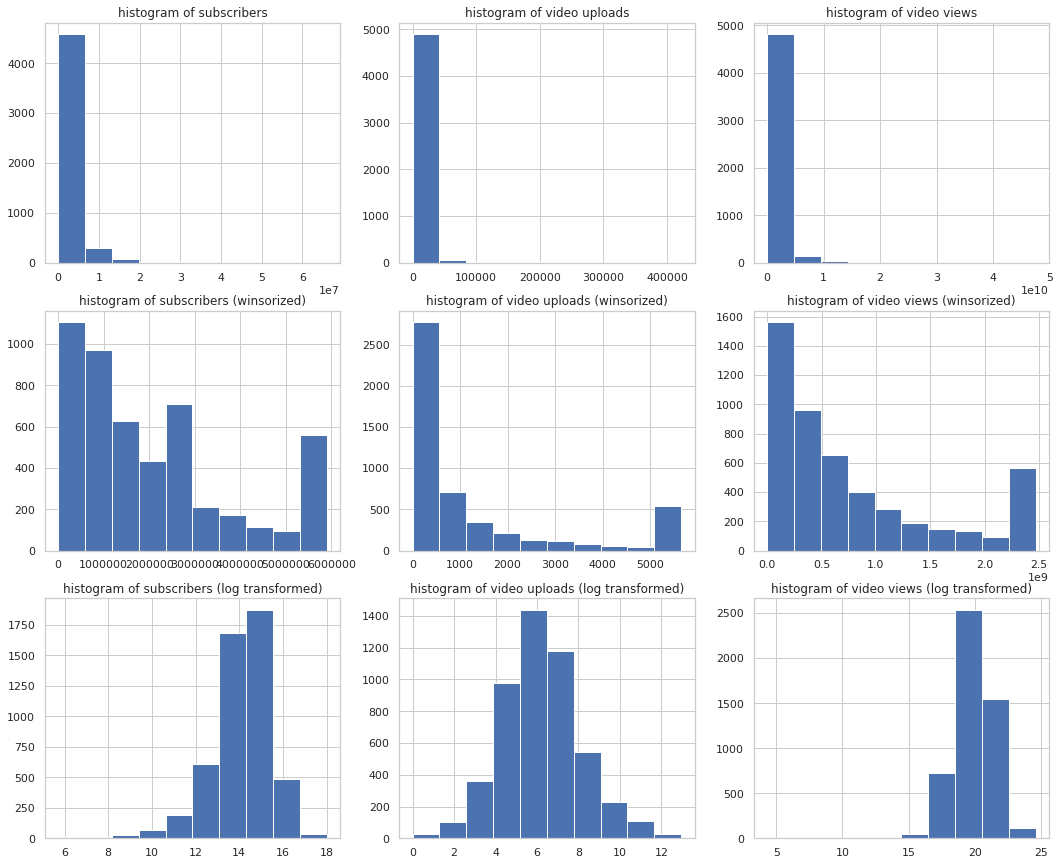

In [5]:
plt.figure(figsize=(18,15))

# histograms of the original data
plt.subplot(3, 3, 1)
plt.hist(youtube_df["Subscribers"])
plt.title("histogram of subscribers")

plt.subplot(3, 3, 2)
plt.hist(youtube_df["Video Uploads"])
plt.title("histogram of video uploads")

plt.subplot(3, 3, 3)
plt.hist(youtube_df["Video views"])
plt.title("histogram of video views")

# histograms of the winsorized data
plt.subplot(3, 3, 4)
plt.hist(youtube_df["winsorized_subscribers"])
plt.title("histogram of subscribers (winsorized)")

plt.subplot(3, 3, 5)
plt.hist(youtube_df["winsorized_uploads"])
plt.title("histogram of video uploads (winsorized)")

plt.subplot(3, 3, 6)
plt.hist(youtube_df["winsorized_views"])
plt.title("histogram of video views (winsorized)")

# histograms of the log transformed data
plt.subplot(3, 3, 7)
plt.hist(np.log(youtube_df["Subscribers"]))
plt.title("histogram of subscribers (log transformed)")

plt.subplot(3, 3, 8)
plt.hist(np.log(youtube_df["Video Uploads"]))
plt.title("histogram of video uploads (log transformed)")

plt.subplot(3, 3, 9)
plt.hist(np.log(youtube_df["Video views"]))
plt.title("histogram of video views (log transformed)")


plt.show()

The histograms of the original and winsorized variables demonstrate highly skewed distributions. However, the distributions of the log-transformed values approach the normal distribution. When we begin to discuss machine learning models later in the bootcamp, we'll clarify why normal distributions are so important for many data science models. But here, we want to highlight log-transforming the 3 variables not only helps us to mitigate the effects of the outliers but also enables us to use models that require normally distributed target variables.

### Univariate visualization of categorical variables

Visualizing categorical variables is slightly different than continuous variables because categorical variables take only limited number of values. One of the most commonly used chart types for categorical features is the bar chart. Below, we draw a bar chart that shows the number of observations for each value in the *Grade* variable:

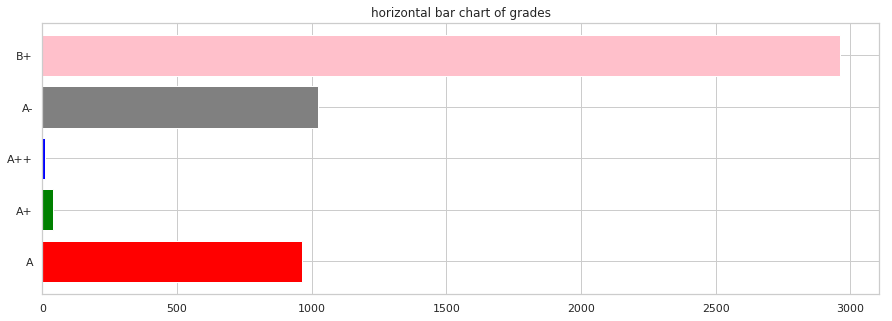

In [6]:
# bar chart of grades
plt.figure(figsize=(15,5))
plt.barh(youtube_df.groupby("Grade")["Grade"].count().index, 
        youtube_df.groupby("Grade")["Grade"].count(), 
        color=["red","green","blue","grey","pink"])
plt.title("horizontal bar chart of grades")

plt.show()

As the bar chart demonstrates, observation counts are not the same across the groups of grades. The most common grade type is *B+*, whereas the least common is *A++*. Knowing this imblance is important. Especially in classification models (which we will cover in a later module), if our target variable exhibits an imbalance across categories, we will need to apply special techniques.

Many variables come in string format and includes text. We usually handle text variables as categorical variables. One common technique in exploring the text features is to look at the most frequently used words. A useful chart type for this purpose is called **word cloud**. Let's investigate the *Channel name* variable using this visualization technique. To be able to draw word clouds, we first need to install the `wordcloud` package using:

`pip install wordcloud`

After that we can use it as follows:

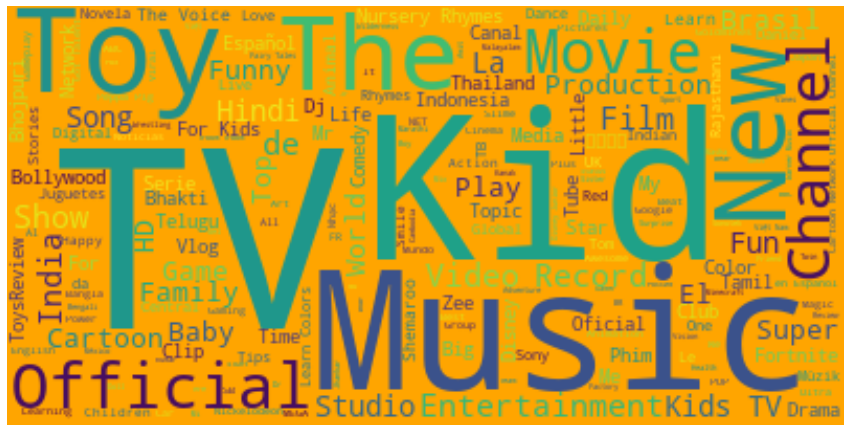

In [6]:
from wordcloud import WordCloud

# Generate a word cloud image
wordcloud = WordCloud(background_color="orange").generate(" ".join(youtube_df["Channel name"]))
plt.figure(figsize=(15,10))
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.show()


As we can see, the most occurring words are: Kid, Toy, TV, Music, New, Movie, Official, Channel, etc. This gives signs our dataset might include a lot of channels for kids! This insight is important. For example, if we want to analyze the channels only for adults, this dataset might be the wrong example or at least we may try to exclude the channels for kids from the dataset. That is related to the *population vs. sample* dichotomy, and, in some cases, visualizations like word clouds, help us in getting some sense of what text variables are about.